<a href="https://colab.research.google.com/github/allan-gon/DS-Unit-2-Kaggle-Challenge/blob/master/module1-decision-trees/LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [3]:
from pandas_profiling import ProfileReport
#profile = ProfileReport(train, minimal=True).to_notebook_iframe()

#profile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Imports

In [4]:
import numpy as np

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [5]:
def wrangle(x):
  df = x.copy()
  #dropping
  df.drop(['recorded_by','date_recorded','quantity_group'],axis=1,inplace=True)#dont drop id but i think dont include in model train
  #replace latitude close to 0 values with 0
  df.latitude.replace({-2.000000e-08:0},inplace=True)
  # replace -s with anans here
  cols_with_zeros = ['longitude', 'latitude']
  for col in cols_with_zeros:
    df[col] = df[col].replace(0, np.nan)

  return df

In [6]:
train = wrangle(train)
test = wrangle(test)

# this removes the nans and puts other..., what its supposed to do is just lower each categorical columns cardinality

In [7]:
for i in ['funder','installer','wpt_name','subvillage','lga','ward','scheme_name']:
  top10 = train[i].value_counts()[:10].index
  train.loc[~train[i].isin(top10), i] = 'OTHER'
  test.loc[~test[i].isin(top10), i] = 'OTHER'


In [8]:
train.isnull().sum()

id                          0
amount_tsh                  0
funder                      0
gps_height                  0
installer                   0
longitude                1812
latitude                 1812
wpt_name                    0
num_private                 0
basin                       0
subvillage                  0
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting           3334
scheme_management        3877
scheme_name                 0
permit                   3056
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
source                      0
source_typ

In [9]:
train.shape

(59400, 38)

In [10]:
test.shape

(14358, 37)

In [11]:
test.isnull().sum()

id                         0
amount_tsh                 0
funder                     0
gps_height                 0
installer                  0
longitude                436
latitude                 436
wpt_name                   0
num_private                0
basin                      0
subvillage                 0
region                     0
region_code                0
district_code              0
lga                        0
ward                       0
population                 0
public_meeting           785
scheme_management        939
scheme_name                0
permit                   663
construction_year          0
extraction_type            0
extraction_type_group      0
extraction_type_class      0
management                 0
management_group           0
payment                    0
payment_type               0
water_quality              0
quality_group              0
quantity                   0
source                     0
source_type                0
source_class  

In [12]:
print(f"{test.dropna().shape},   {train.dropna().shape}")# i think its ok to drop here
#test.dropna(inplace=True)# i cant drop nans in test because i need an answer for each column
train.dropna(inplace=True)# i can here but i need to figure out what i wan tto do with the ananas in test

(11809, 37),   (48505, 38)


In [13]:
test.head(2)

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,OTHER,1996,OTHER,35.290799,-4.059696,OTHER,0,Internal,OTHER,Manyara,21,3,OTHER,OTHER,321,True,Parastatal,OTHER,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,Government Of Tanzania,1569,DWE,36.656709,-3.309214,OTHER,0,Pangani,OTHER,Arusha,2,2,Arusha Rural,OTHER,300,True,VWC,OTHER,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe


In [14]:
X_train,X_val,y_train,y_val = train_test_split(train.dropna().drop('status_group',axis=1),train.dropna().status_group,test_size=.2)

In [15]:
pipe_model = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(n_jobs=-1)
)

# Fit
pipe_model.fit(X_train, y_train);

In [16]:
print(f"Val Score: {pipe_model.score(X_val,y_val)}")
print(f"Train Score: {pipe_model.score(X_train,y_train)}")
print(f"Baseline: {max(train.status_group.value_counts(normalize=True))}")

Val Score: 0.7428100195856098
Train Score: 0.7461859602102876
Baseline: 0.5522935779816514


In [17]:
pipe_model.predict(test)

array(['non functional', 'functional', 'non functional', ...,
       'non functional', 'functional', 'non functional'], dtype=object)

In [18]:
test.shape

(14358, 37)

In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14358 entries, 0 to 14357
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14358 non-null  int64  
 1   amount_tsh             14358 non-null  float64
 2   funder                 14358 non-null  object 
 3   gps_height             14358 non-null  int64  
 4   installer              14358 non-null  object 
 5   longitude              13922 non-null  float64
 6   latitude               13922 non-null  float64
 7   wpt_name               14358 non-null  object 
 8   num_private            14358 non-null  int64  
 9   basin                  14358 non-null  object 
 10  subvillage             14358 non-null  object 
 11  region                 14358 non-null  object 
 12  region_code            14358 non-null  int64  
 13  district_code          14358 non-null  int64  
 14  lga                    14358 non-null  object 
 15  wa

In [20]:
tree_pipe = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier()
)

In [21]:
tree_pipe.fit(X_train,y_train);

In [22]:
print(f"Val Score: {tree_pipe.score(X_val,y_val)}")
print(f"Train Score: {tree_pipe.score(X_train,y_train)}")
print(f"Baseline: {max(train.status_group.value_counts(normalize=True))}")

Val Score: 0.7443562519327904
Train Score: 1.0
Baseline: 0.5522935779816514


In [28]:
y_pred = tree_pipe.predict(test)

In [29]:
DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('second_try.csv', index=False)

from google.colab import files
files.download('second_try.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
test.isnull().sum()

id                         0
amount_tsh                 0
funder                     0
gps_height                 0
installer                  0
longitude                436
latitude                 436
wpt_name                   0
num_private                0
basin                      0
subvillage                 0
region                     0
region_code                0
district_code              0
lga                        0
ward                       0
population                 0
public_meeting           785
scheme_management        939
scheme_name                0
permit                   663
construction_year          0
extraction_type            0
extraction_type_group      0
extraction_type_class      0
management                 0
management_group           0
payment                    0
payment_type               0
water_quality              0
quality_group              0
quantity                   0
source                     0
source_type                0
source_class  

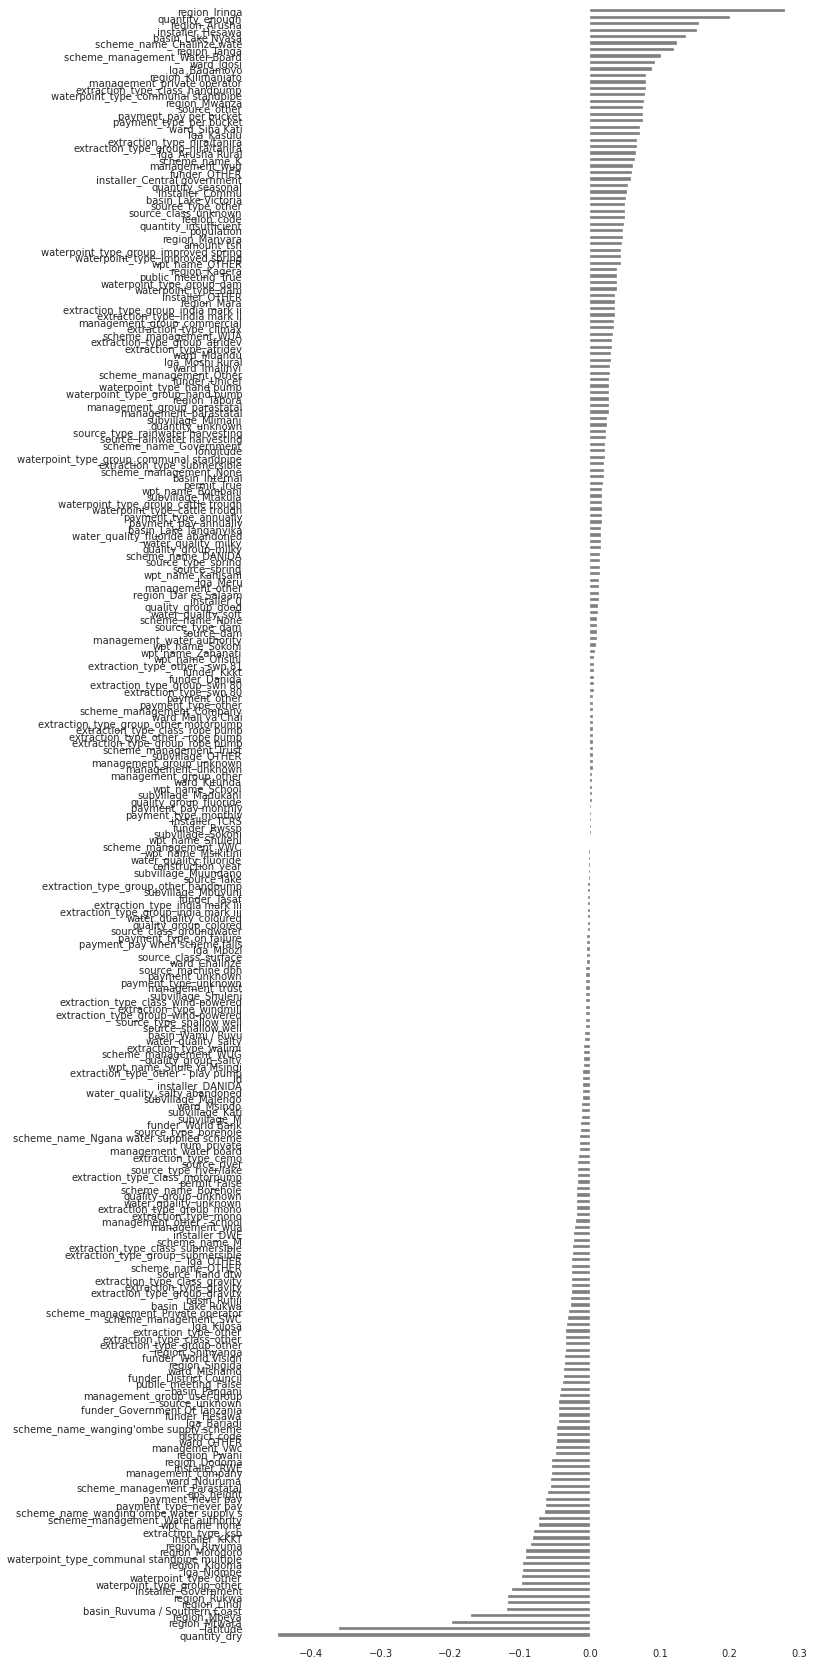

In [27]:
import matplotlib.pyplot as plt

model = pipe_model.named_steps['logisticregression']
encoder = pipe_model.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

In [30]:
y_pred.shape

(14358,)

In [32]:
test.shape[0]

14358

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
forest_pipe = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier()
)

In [35]:
forest_pipe.fit(X_train,y_train);

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['funder', 'installer', 'wpt_name', 'basin',
                                     'subvillage', 'region', 'lga', 'ward',
                                     'public_meeting', 'scheme_management',
                                     'scheme_name', 'permit', 'extraction_type',
                                     'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_gr...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [36]:
print(f"Val Score: {forest_pipe.score(X_val,y_val)}")
print(f"Train Score: {forest_pipe.score(X_train,y_train)}")
print(f"Baseline: {max(train.status_group.value_counts(normalize=True))}")

Val Score: 0.8087825997319864
Train Score: 0.999922688382641
Baseline: 0.5522935779816514


In [37]:
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('third_try.csv', index=False)
files.download('third_try.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>